<div style="background-color:#f2f2f2; padding: 20px; border-radius: 10px;">
    <h1 style="color:#2c3e50;">Introduction to Vehicle Movement Tracking with PINN and UKF</h1>
    <p>
        In this project,develop a system that predicts vehicle movement using Physics-Informed Neural Networks (PINN) and
        Unscented Kalman Filters (UKF). The system generates synthetic vehicle movement data and uses a combination of machine
        learning and filtering techniques to estimate the vehicle's position accurately.
    </p>
    <h3>Data Flow Overview:</h3>
    <ol>
        <li>Data Generation: Simulate noisy vehicle movement data including position, velocity, and acceleration.</li>
        <li>Pinn Training: Train the PINN model to predict future positions based on the current state.</li>
        <li>Evaluation: Assess the accuracy of the combined system using error metrics like MSE and MAE.</li>
        <li>UKF Integration: Use UKF to refine predictions using noisy GPS measurements and model predictions.</li>
    </ol>
    <img src="https://www.mdpi.com/sensors/sensors-23-06665/article_deploy/html/images/sensors-23-06665-g002-550.jpg" alt="chart" />

</div>

<div style="background-color:#e8f4f8; padding: 20px; border-radius: 10px;">
    <h2 style="color:#2980b9;">1. Data Generation Process</h2>
    <p>
        The dataset simulates the motion of a vehicle under random accelerations. At each time step, we update the vehicle's
        velocity and position using kinematic equations, then introduce noise to the position measurements to mimic real-world
        GPS errors.
    </p>
    <h3>Key Parameters:</h3>
    <ul>
        <li><strong>Time Step (dt):</strong> The interval between consecutive measurements.</li>
        <li><strong>Max Velocity and Acceleration:</strong> The maximum velocity and acceleration for the vehicle's movement.</li>
        <li><strong>Noise Level:</strong> The standard deviation of the noise added to the position measurements.</li>
    </ul>
</div>


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Parameters
num_samples = 1000  # Number of samples in the dataset
dt = 0.1  # Time step (seconds)
max_velocity = 20.0  # Maximum velocity (m/s)
max_acceleration = 2.0  # Maximum acceleration (m/s^2)
noise_level = 0.5  # Noise level for position

data = []

# Conditions
x, y = 0.0, 0.0  # Initial position
vx, vy = 10.0, 0.0  # Initial velocity
ax, ay = 0.0, 0.0  # Initial acceleration

for i in range(num_samples):
    # Random acceleration
    ax = np.random.uniform(-max_acceleration, max_acceleration)
    ay = np.random.uniform(-max_acceleration, max_acceleration)

    # Update velocity
    vx = vx + ax * dt
    vy = vy + ay * dt

    # Update position
    x_next = x + vx * dt + 0.5 * ax * (dt ** 2)
    y_next = y + vy * dt + 0.5 * ay * (dt ** 2)

    # Add noise to position
    x_next_noisy = x_next + np.random.normal(0, noise_level)
    y_next_noisy = y_next + np.random.normal(0, noise_level)

    data.append([x, y, vx, vy, ax, ay, x_next_noisy, y_next_noisy])
    x, y = x_next, y_next

columns = ['x', 'y', 'vx', 'vy', 'ax', 'ay', 'x_next', 'y_next']
df = pd.DataFrame(data, columns=columns)
df.head()
df.to_csv('vehicle_movement_dataset.csv', index=False)


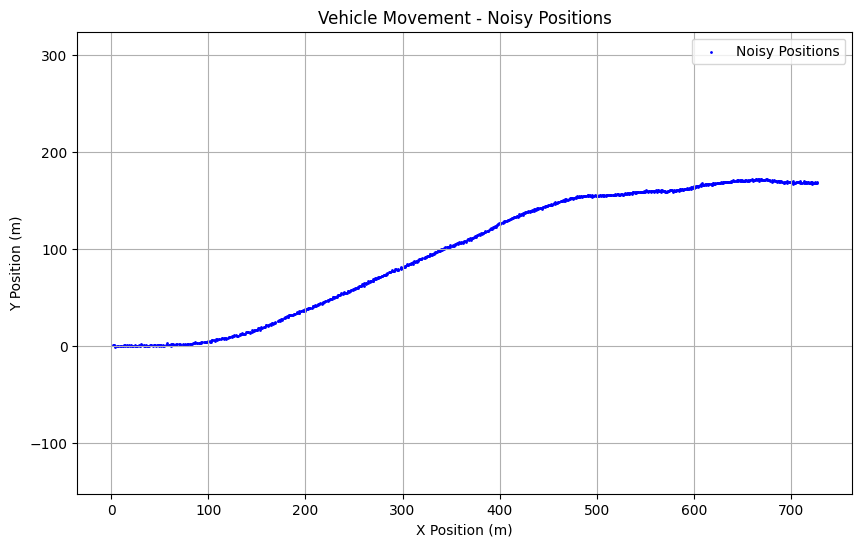

In [ ]:
import matplotlib.pyplot as plt

# Plot the noisy positions
plt.figure(figsize=(10, 6))
plt.scatter(df['x_next'], df['y_next'], c='blue', s=1, label='Noisy Positions')
plt.title('Vehicle Movement - Noisy Positions')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

<div style="background-color:#fce4ec; padding: 20px; border-radius: 10px;">
    <h2 style="color:#e91e63;">2. Physics-Informed Neural Networks (PINN)</h2>
    <p>
        A Physics-Informed Neural Network (PINN) is a type of neural network that incorporates known physical laws into its loss
        function. In this project, the PINN is designed to predict the next position of the vehicle based on the current state
        (position, velocity, and acceleration).
    </p>
    <h3>PINN Architecture:</h3>
<ul>
    <li>
        <strong>Input Layer:</strong> The input consists of the current state [x, y, vx, vy, ax, ay].
        <ul>
            <li><strong>Position (x, y):</strong> The current position of the vehicle.</li>
            <li><strong>Velocity (vx, vy):</strong> The current velocity of the vehicle.</li>
            <li><strong>Acceleration (ax, ay):</strong> The acceleration of the vehicle, which may depend on factors like engine force, friction, and external forces like wind.</li>
        </ul>
    </li>
    <li><strong>Hidden Layers:</strong> Two hidden layers with ReLU activation functions to capture non-linear relationships.</li>
    <li><strong>Output Layer:</strong> Predicts the next position [x_next, y_next].</li>
</ul>

<h3>Loss Functions:</h3>
<ul>
    <li><strong>Data Loss:</strong> Measures the difference between predicted and true next positions using Mean Squared Error (MSE).</li>
    <li><strong>Physics Loss:</strong> Ensures the predicted positions satisfy the kinematic equations:</li>
</ul>

</div>

$
x_{\text{next}} = x_{\text{current}} + v_x \cdot \Delta t + \frac{1}{2} a_x \cdot (\Delta t)^2
$

$
y_{\text{next}} = y_{\text{current}} + v_y \cdot \Delta t + \frac{1}{2} a_y \cdot (\Delta t)^2
$
<p>
    The total loss is given by the equation <br> $ \text{Total Loss} = \text{Data Loss} + \lambda \cdot \text{Physics Loss} $. <br>
    Where
𝜆
λ is a hyperparameter that controls the trade-off between data accuracy and physical consistency. <br>
    This represents a weighted sum of the data and physics losses, encouraging the network to make predictions that align
    with both the data and the underlying physical model.
</p>



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(6, 64)  # Input: x, y, vx, vy, ax, ay
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # Output: x_next, y_next

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Physics Loss
def physics_loss(pred, current, dt):
    x_current, y_current = current[:, 0], current[:, 1]
    vx, vy = current[:, 2], current[:, 3]
    ax, ay = current[:, 4], current[:, 5]
    x_pred, y_pred = pred[:, 0], pred[:, 1]

    # Kinematic equations with acceleration
    x_next_true = x_current + vx * dt + 0.5 * ax * (dt ** 2)
    y_next_true = y_current + vy * dt + 0.5 * ay * (dt ** 2)

    loss_x = torch.mean((x_pred - x_next_true) ** 2)
    loss_y = torch.mean((y_pred - y_next_true) ** 2)

    return loss_x + loss_y

# Define the training loop
def train_pinn(model, data, optimizer, dt, epochs=1000, lambda_phy=1.0):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Extract inputs and true positions
        current_state, true_next_position = data[:, :6], data[:, 6:]

        # Predict next position
        pred_next_position = model(current_state)

        # Compute losses
        data_loss = nn.MSELoss()(pred_next_position, true_next_position)
        phy_loss = physics_loss(pred_next_position, current_state, dt)

        # Total loss
        loss = data_loss + lambda_phy * phy_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


data = df.values
data = torch.tensor(data, dtype=torch.float32)

pinn = PINN()
optimizer = optim.Adam(pinn.parameters(), lr=0.001)

# Train the PINN with the loaded data
train_pinn(pinn, data, optimizer, 0.1)


Epoch 0, Loss: 329590.5625
Epoch 100, Loss: 408.04437255859375
Epoch 200, Loss: 162.6307373046875
Epoch 300, Loss: 0.6577672958374023
Epoch 400, Loss: 0.3090653121471405
Epoch 500, Loss: 0.2953270673751831
Epoch 600, Loss: 0.2883521616458893
Epoch 700, Loss: 0.2832537293434143
Epoch 800, Loss: 0.279255747795105
Epoch 900, Loss: 0.2757125496864319


<div style="background-color:#fff9c4; padding: 20px; border-radius: 10px;">
    <h2 style="color:#f57f17;">3. Model Evaluation</h2>
    <p>
        After training the PINN model, we evaluate its performance by comparing the predicted positions against the true positions.
        The evaluation is based on the following metrics:
    </p>
    <ul>
        <li><strong>Mean Squared Error (MSE):</strong> The average of the squared differences between predicted and true positions.</li>
        <li><strong>Mean Absolute Error (MAE):</strong> The average of the absolute differences between predicted and true positions.</li>
    </ul>
    <p>
        Visualization plots are used to compare the true positions, GPS measurements, and UKF-estimated positions, providing insights
        into the model's accuracy.
    </p>
</div>


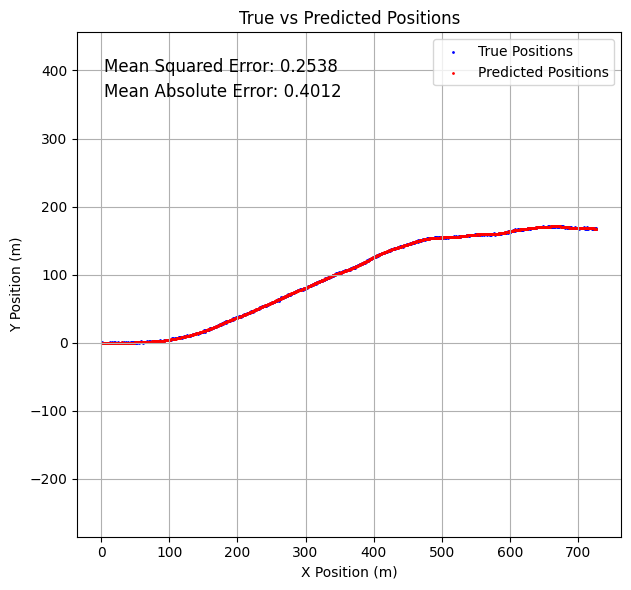

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# evaluate the model and visualize predictions
def evaluate_pinn(model, data, dt):
    model.eval()

    # Extract inputs and true positions
    if isinstance(data, torch.Tensor):
        data = data.numpy()
    current_state, true_next_position = data[:, :6], data[:, 6:]
    current_state_tensor = torch.from_numpy(current_state).float()

    # Make predictions
    with torch.no_grad():
        pred_next_position = model(current_state_tensor)

    pred_next_position_np = pred_next_position.numpy()
    true_next_position = np.array(true_next_position)

    # Calculate error metrics
    mse = np.mean((pred_next_position_np - true_next_position) ** 2)
    mae = np.mean(np.abs(pred_next_position_np - true_next_position))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(true_next_position[:, 0], true_next_position[:, 1], color='blue', s=1, label='True Positions')
    plt.scatter(pred_next_position_np[:, 0], pred_next_position_np[:, 1], color='red', s=1, label='Predicted Positions')
    plt.title('True vs Predicted Positions')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid()
    plt.legend()

    # Add MSE and MAE to the plot
    plt.text(0.05, 0.95, f'Mean Squared Error: {mse:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.05, 0.90, f'Mean Absolute Error: {mae:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Evaluate the trained PINN
evaluate_pinn(pinn, data, dt)

<div style="background-color:#e8f5e9; padding: 20px; border-radius: 10px;">
    <h2 style="color:#43a047;">4. Unscented Kalman Filter (UKF)</h2>
    <p>
        The Unscented Kalman Filter (UKF) is an advanced state estimation technique used to track the position of the vehicle. It works
        by predicting the next state of the system and then updating the prediction based on noisy measurements. The UKF is particularly
        effective in non-linear systems like ours.
    </p>
    <h3>UKF Mathematical Model:</h3>
    <ul>
        <li><strong>State Vector:</strong> The state includes position, velocity, and acceleration [x, y, vx, vy, ax, ay].</li>
        <li><strong>Process Model (fx):</strong> Describes how the state evolves over time:</li>
    </ul>
</div>

$
x_{k+1} = f(x_k) + w_k
$
where $ w_k $ is process noise.

<ul>
    <li><strong>Measurement Model (hx):</strong> Relates the state to the measurements:</li>
</ul>

$
y_k = h(x_k) + v_k
$
where $ v_k $ is measurement noise.

<h3>UKF Steps:</h3>
<ol>
    <li><strong>Prediction:</strong> Predict the next state using the process model.</li>
    <li><strong>Update:</strong> Correct the prediction using the noisy GPS measurements.</li>
</ol>
<p>
    The UKF iteratively performs these steps, refining its state estimate to minimize the prediction error.
</p>
<h3>Noise Matrices:</h3>
<ul>
    <li><strong>Process Noise (Q):</strong> Represents the uncertainty in the process model.</li>
    <li><strong>Measurement Noise (R):</strong> Represents the uncertainty in the measurements.</li>
</ul>


<div style="background-color:#fafafa; padding: 20px; border-left: 5px solid #9e9e9e; padding-left: 20px; margin: 20px 0;">
    <h2 style="color:#607d8b;">UKF Workflow</h2>
    <ul>
        <li><strong>Initialization:</strong> Initialize the state vector and covariance matrices.</li>
        <li><strong>Prediction Step:</strong> Predict the next state using the process model.</li>
        <li><strong>Update Step:</strong> Update the state estimate using the measurement model.</li>
        <li><strong>Repeat:</strong> Iterate over the dataset, refining predictions with each new measurement.</li>
    </ul>
    <p>
        This process continues until the entire dataset has been processed, producing a refined estimate of the vehicle's position over time.
    </p>
      <img src="https://www.mdpi.com/computers/computers-11-00165/article_deploy/html/images/computers-11-00165-g001-550.jpg" alt="chart" />
</div>


In [ ]:
!pip install filterpy

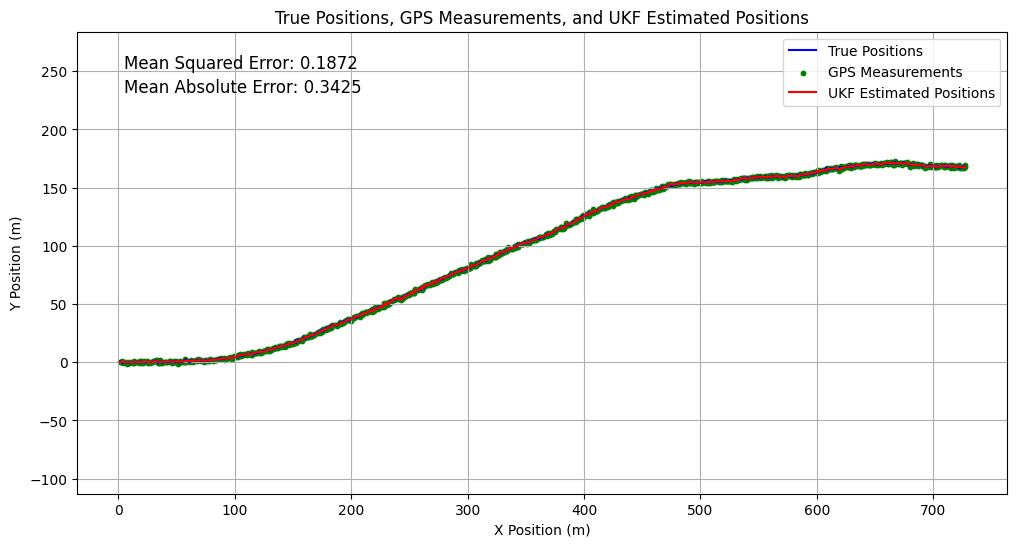

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

# simulate Gaussian noisy GPS measurements
def simulate_gps_measurements(true_positions, noise_std=1.0):
    gps_measurements = true_positions + np.random.normal(0, noise_std, true_positions.shape)
    return gps_measurements

# Define the measurement function for the UKF (GPS readings)
def hx(x):
    return np.array([x[0], x[1]])

# State [x_position, y_position, vx, vy, ax, ay]
points = MerweScaledSigmaPoints(n=6, alpha=0.1, beta=2.0, kappa=0)
ukf = UKF(dim_x=6, dim_z=2, fx=None, hx=hx, dt=0.1, points=points)

# Initial state estimate
initial_state = np.array([df['x'][0], df['y'][0], df['vx'][0], df['vy'][0], df['ax'][0], df['ay'][0]])
ukf.x = initial_state

# Process and measurement noise
ukf.R = np.diag([0.5, 0.5])  # measurement noise
ukf.Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.01, 0.01])  # noise levels for position, velocity, acceleration
ukf.P *= 0.1  # Reduce initial state covariance

# predict the next state using the PINN
def predict_with_pinn(current_state, pinn_model):
    current_state_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        next_position = pinn_model(current_state_tensor).numpy().flatten()
    # Update the state vector with predicted position, keeping velocities and accelerations the same
    return np.array([next_position[0], next_position[1], current_state[2], current_state[3], current_state[4], current_state[5]])

# Replace UKF's prediction step with the PINN
def pinn_fx(x, dt):
    return predict_with_pinn(x, pinn)

estimated_positions = []
gps_measurements = []

# Loop over the dataset
for i in range(len(df)):
    # Get current true state and GPS measurement
    true_position = np.array([df['x_next'][i], df['y_next'][i]])
    gps_measurement = simulate_gps_measurements(true_position, noise_std=0.5)

    # UKF Prediction step using PINN
    ukf.predict(fx=pinn_fx)

    # UKF Update step with noisy GPS measurement
    ukf.update(gps_measurement)

    estimated_positions.append(ukf.x[:2])
    gps_measurements.append(gps_measurement)

estimated_positions = np.array(estimated_positions)
gps_measurements = np.array(gps_measurements)

# Calculate Mean Squared Error and Mean Absolute Error
mse = np.mean((estimated_positions - df[['x_next', 'y_next']].values) ** 2)
mae = np.mean(np.abs(estimated_positions - df[['x_next', 'y_next']].values))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df['x_next'], df['y_next'], color='blue', label='True Positions')
plt.scatter(gps_measurements[:, 0], gps_measurements[:, 1], color='green', s=10, label='GPS Measurements')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], color='red', label='UKF Estimated Positions')

# Add MSE and MAE to the plot
plt.text(0.05, 0.95, f'Mean Squared Error: {mse:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Mean Absolute Error: {mae:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title('True Positions, GPS Measurements, and UKF Estimated Positions')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()